## Homework 1: Finding submarines
Cassia Cai <br> fmc2855@uw.edu

#### Goal: locate a submarine in the Puget Sound using noisy acoustic data

We do not know much about this submarine as it is a new technology that emits an unknown acoustic frequency that you need to detect. Unfortunately the submarine is moving so its location and path need to be determined.

Broad spectrum recording of acoustics data obtained over 24 hours in half-hour increments is available to you. The data file contain a matrix with 49 columns of data corresponding to the measurements of acoustic pressure taken over 24 hours. The measurements themselves are 3D and taken on a uniform grid of size 64 × 64 × 64. The provided notebook will visualize this data for you. 

Tasks:
1. Through averaging of the Fourier transform and visual inspection, determine the frequency signature (center frequency) generated by the submarine.
2. Design and implement a Filter to extract this frequency signature in order to denoise the data and determine the path of the submarine. You can also plot the 3D path of the submarine if you like.
3. Determine and plot the 𝑥, 𝑦 coordinates of the submarine during the 24 hour period. This information can be used to deploy a sub-tracking aircraft to keep an eye on your submarine in the future.

Note: All plotting code has been commented out.

In [2]:
#  ------------------ import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib.colors import LogNorm
import scipy 
from scipy import ndimage

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 

In [4]:
# ------------------ load acoustic data
# data_path = 'subdata.npy'
data_path = #path of your data

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

In [5]:
# ------------------ from helper code
L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction

K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate
k1, k2 = np.meshgrid(K_grid, K_grid)

In [6]:
# Attempt without filtering and denoising
kz3, ky3, kx3 = np.meshgrid(K_grid, K_grid, K_grid)

x_posit_nofilt= []; y_posit_nofilt = []; z_posit_nofilt = []

fft_full = np.ndarray((64,64,64,49))
for t in np.arange(49):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft = np.fft.fftshift(np.fft.fftn(signal))
    fft_full[:,:,:,t] = fft
    max_pos_nofilt = np.unravel_index(fft.argmax(), fft.shape)
    x_posit_nofilt.append(max_pos_nofilt[0]); y_posit_nofilt.append(max_pos_nofilt[1]); z_posit_nofilt.append(max_pos_nofilt[2])
    
x_posit_unfilt_on_K_grid = []; y_posit_unfilt_on_K_grid = [];z_posit_unfilt_on_K_grid = []
for i in range(len(x_posit_nofilt)):
    x_posit_unfilt_on_K_grid.append(K_grid[x_posit_nofilt[i]])
    y_posit_unfilt_on_K_grid.append(K_grid[y_posit_nofilt[i]])
    z_posit_unfilt_on_K_grid.append(K_grid[z_posit_nofilt[i]])
    

<ipython-input-6-389edb07008e>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_full[:,:,:,t] = fft


In [36]:
# ########### Plot of figure without any denoising or filtering
# fig = plt.figure(figsize=plt.figaspect(.4))

# ax = fig.add_subplot(1, 2, 1)
# ax.text(-7, -6, '(a)', horizontalalignment='center',verticalalignment='center',fontsize=25)
# ax.plot(x_posit_unfilt_on_K_grid, y_posit_unfilt_on_K_grid, 'bo',
#         x_posit_unfilt_on_K_grid, y_posit_unfilt_on_K_grid, 'k--', markerfacecolor='purple')
# ax.set_ylabel('ky',fontsize=15)
# ax.set_xlabel('kx',fontsize=15)
# ax.tick_params(labelsize=14)

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.azim = -30; ax.dist = 7; ax.elev = 20
# ax.text(-6, -8,7, '(b)', horizontalalignment='center',verticalalignment='center',fontsize=25)
# ax.plot3D(x_posit_unfilt_on_K_grid, y_posit_unfilt_on_K_grid, z_posit_unfilt_on_K_grid,c='purple')
# ax.scatter(x_posit_unfilt_on_K_grid, y_posit_unfilt_on_K_grid, z_posit_unfilt_on_K_grid,c='purple')
# ax.set_xlabel('kx',fontsize=15); ax.set_ylabel('ky',fontsize=15); ax.set_zlabel('kz',fontsize=15)
# ax.tick_params(labelsize=14)

# plt.show()

In [8]:
# ------------------ compute fft of the original signal and locate the center frequency of the submarine
fft = np.ndarray((64,64,64,49))
len_time = 49

for t in np.arange(len_time):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft[:,:,:,t] = np.fft.fftshift(np.fft.fftn(signal))# .real why is it different if I put real here
signal_normalized = np.abs(signal)/np.abs(signal).max()

# Locate the center frequency of the sub
fft_ave = np.sum(fft, axis=3) / len_time

freq_max = np.where(fft_ave == np.amax(fft_ave))
# freq_max = np.unravel_index(fft_ave.argmax(), fft_ave.shape)

<ipython-input-8-ef9b0ef37a5b>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  fft[:,:,:,t] = np.fft.fftshift(np.fft.fftn(signal))# .real why is it different if I put real here


In [9]:
Kx, Ky, Kz = np.meshgrid(K_grid, K_grid,K_grid)

In [10]:
print(freq_max) # these are my two maximum points

(array([26, 38]), array([17, 47]), array([55,  9]))


In [11]:
x_ = K_grid[freq_max[1][0]]
y_ = K_grid[freq_max[0][0]]
z_ = K_grid[freq_max[2][0]]

x_opp = K_grid[freq_max[1][1]]
y_opp = K_grid[freq_max[0][1]]
z_opp = K_grid[freq_max[2][1]]

print('center frequency 1: ', x_, y_, z_)    
print('center frequency 2: ', x_opp, y_opp, z_opp)

center frequency 1:  -4.71238898038469 -1.8849555921538759 7.225663103256524
center frequency 2:  4.71238898038469 1.8849555921538759 -7.225663103256524


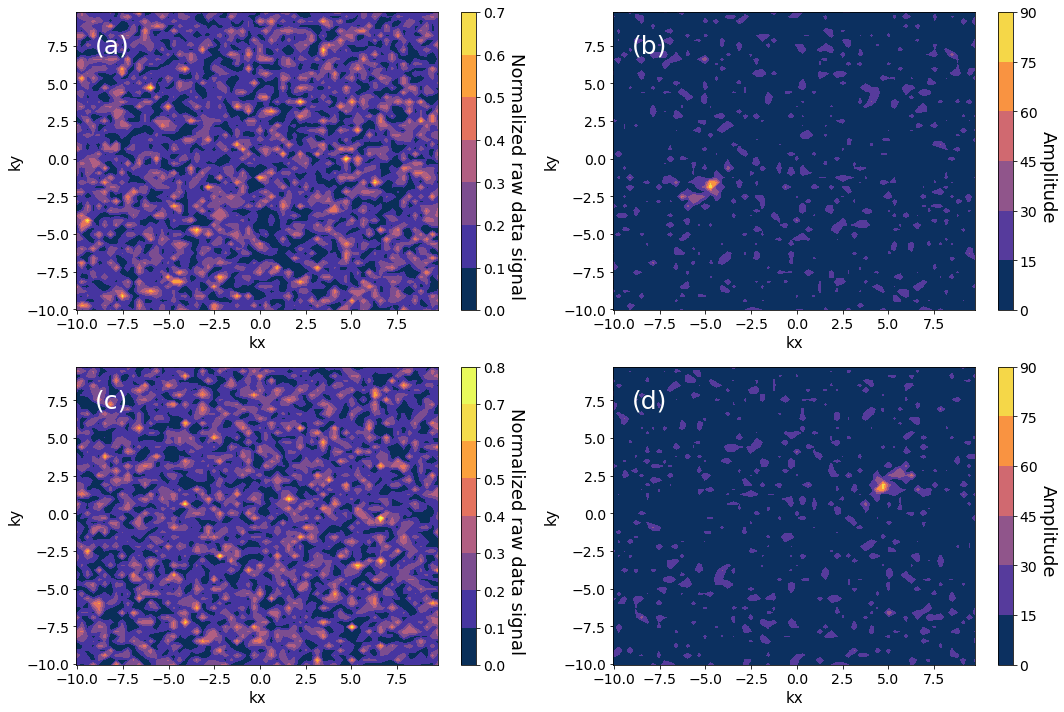

In [12]:
import cmocean

plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(2, 2, 1); 
plt.text(-9, 7.0, '(a)', fontsize = 25,c='white')
plt.contourf(k1, k2, np.abs(signal_normalized[:,:,55]), cmap=cmocean.cm.thermal, vmin=0,vmax=0.7)
plt.xlabel('kx',fontsize=15); plt.ylabel('ky',fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.set_label('Normalized raw data signal', labelpad=20, y=0.45,fontsize=18, rotation=270)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 

plt.subplot(2, 2, 2)
plt.text(-9, 7.0, '(b)', fontsize = 25,c='white')
plt.contourf(k1, k2, np.abs(fft_ave[:,:,55]),cmap=cmocean.cm.thermal, vmin=0,vmax=90)
plt.xlabel('kx',fontsize=15); plt.ylabel('ky',fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=18, rotation=270)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 

plt.subplot(2, 2, 3)
plt.text(-9, 7.0, '(c)', fontsize = 25,c='white')
#plt.title('normalized raw data signal at z-level = 9',fontsize=13)
plt.contourf(k1, k2, np.abs(signal_normalized[:,:,9]), cmap=cmocean.cm.thermal, vmin=0,vmax=0.7)
plt.xlabel('kx',fontsize=15); plt.ylabel('ky',fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.set_label('Normalized raw data signal', labelpad=20, y=0.45,fontsize=18, rotation=270)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 

plt.subplot(2, 2, 4)
plt.text(-9, 7.0, '(d)', fontsize = 25,c='white')
plt.contourf(k1, k2, np.abs(fft_ave[:,:,9]),cmap=cmocean.cm.thermal, vmin=0,vmax=90)
plt.xlabel('kx',fontsize=15); plt.ylabel('ky',fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=18, rotation=270)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 

plt.tight_layout()
plt.savefig('figure1.pdf')

plt.show()

### Gaussian Filters

In [13]:
def shift(index):
    shift = (index - 32) * 2*L / 64
    return shift
# ------------------------------------ a gaussian filter
def g_centered(x, y, z, s):
    x_shift = shift(freq_max[1][1])
    y_shift = shift(freq_max[0][1])
    z_shift = shift(freq_max[2][1])
    
    x_shift_opp = shift(freq_max[1][0])
    y_shift_opp = shift(freq_max[0][0])
    z_shift_opp = shift(freq_max[2][0])
        
    s_squared = s**2
    guass1 = np.exp(-(((x-x_shift)**2 + (y-y_shift)**2 + (z-z_shift)**2)/(2*s_squared)))
    guass2 = np.exp(-(((x-x_shift_opp)**2 + (y-y_shift_opp)**2 + (z-z_shift_opp)**2)/(2*s_squared)))
    
    val = guass1 + guass2
    return val

### Applying Gaussian filter

In [14]:
# original applying gaussian filter code with one sigma

sigma = 3 # for Gaussian filter

kz3, ky3, kx3 = np.meshgrid(K_grid, K_grid, K_grid)

# frequency in fourier space is kx, ky, and kz
x_posit_gaus = []; y_posit_gaus = []; z_posit_gaus = []; submarine_position_gaus = []; max_val_list_gaus = []

denoised_gaus = np.ndarray((64,64,64,49))
fft_filtered_gaus_full = np.ndarray((64,64,64,49))

fft_full = np.ndarray((64,64,64,49))
g_vals_gaus_full = np.ndarray((64,64,64,49))
for t in np.arange(49):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft = np.fft.fftshift(np.fft.fftn(signal))
    fft_full[:,:,:,t] = fft
    
    g_vals_gaus = g_centered(kx3, ky3, kz3, sigma) # gaussian filter
    g_vals_gaus_full[:,:,:,t] = g_vals_gaus
    fft_filtered_gaus = fft * g_vals_gaus
    fft_filtered_gaus_full[:,:,:,t] = fft_filtered_gaus
    denoised_temp_gaus = np.real(np.fft.ifftn(np.fft.ifftshift(fft_filtered_gaus)))
    denoised_temp_normalized_gaus = np.abs(denoised_temp_gaus)/np.abs(denoised_temp_gaus).max()
    max_pos_gaus = np.unravel_index(denoised_temp_normalized_gaus.argmax(), denoised_temp_normalized_gaus.shape)
    max_val_gaus = np.nanmax(denoised_temp_gaus); max_val_list_gaus.append(max_val_gaus)
    
    submarine_position_gaus.append(max_pos_gaus)    
    x_posit_gaus.append(max_pos_gaus[0]); y_posit_gaus.append(max_pos_gaus[1]); z_posit_gaus.append(max_pos_gaus[2])
    
    denoised_gaus[:,:,:,t] = denoised_temp_gaus

<ipython-input-14-976585e45cd1>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_full[:,:,:,t] = fft
<ipython-input-14-976585e45cd1>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_filtered_gaus_full[:,:,:,t] = fft_filtered_gaus


In [15]:
g_vals_gaus_full_ave = np.sum(g_vals_gaus_full[:,:,:,:], axis=3) / len_time

In [37]:
# import plotly; import plotly.graph_objs as go
# from IPython.display import clear_output # utility for clearing output of cell as loop runs in notebook

# xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
# x = xx[0:N_grid];y = x; z = x

# xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting

# normal_freq_abs = np.abs(g_vals_gaus_full_ave)/np.abs(g_vals_gaus_full_ave).max()

# fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
#                            value = normal_freq_abs.flatten(),isomin=.3, isomax=.7)
# fig = go.Figure(data=fig_data)
# fig.show()

In [17]:
# looping through some sigma values

fft_filtered_gaus_full_full = np.ndarray((64,64,64,49,6))
denoised_gaus_full = np.ndarray((64,64,64,49,6))
g_vals_gaus_full_full = np.ndarray((64,64,64,49,6))

x_posit_gaus_full = []; y_posit_gaus_full = []; z_posit_gaus_full = []
submarine_position_gaus_full = []; max_val_list_gaus_full = []
for sigma in np.arange(6):
    x_posit_gaus = []; y_posit_gaus = []; z_posit_gaus = []; submarine_position_gaus = []; max_val_list_gaus = []
    
    fft_filtered_gaus_full = np.ndarray((64,64,64,49))
    denoised_gaus = np.ndarray((64,64,64,49))
    g_vals_gaus_full = np.ndarray((64,64,64,49))
    for t in np.arange(49):
        signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
        fft = np.fft.fftshift(np.fft.fftn(signal))
        fft_full[:,:,:,t] = fft
        
        g_vals_gaus = g_centered(kx3, ky3, kz3, sigma) 
        g_vals_gaus_full[:,:,:,t] = g_vals_gaus
        fft_filtered_gaus = fft * g_vals_gaus
        fft_filtered_gaus_full[:,:,:,t] = fft_filtered_gaus
        denoised_temp_gaus = np.real(np.fft.ifftn(np.fft.ifftshift(fft_filtered_gaus)))
        denoised_temp_normalized_gaus = np.abs(denoised_temp_gaus)/np.abs(denoised_temp_gaus).max()
        max_pos_gaus = np.unravel_index(denoised_temp_normalized_gaus.argmax(), denoised_temp_normalized_gaus.shape)
        max_val_gaus = np.nanmax(denoised_temp_gaus); max_val_list_gaus.append(max_val_gaus)

        submarine_position_gaus.append(max_pos_gaus)    
        x_posit_gaus.append(max_pos_gaus[0]); y_posit_gaus.append(max_pos_gaus[1]); z_posit_gaus.append(max_pos_gaus[2])

        denoised_gaus[:,:,:,t] = denoised_temp_gaus
    
    x_posit_gaus_full.append(x_posit_gaus)
    y_posit_gaus_full.append(y_posit_gaus)
    z_posit_gaus_full.append(z_posit_gaus)
    submarine_position_gaus_full.append(submarine_position_gaus)
    max_val_list_gaus_full.append(max_val_list_gaus)
    
    fft_filtered_gaus_full_full[:,:,:,:,sigma] = fft_filtered_gaus_full
    denoised_gaus_full[:,:,:,:,sigma] = denoised_gaus
    g_vals_gaus_full_full[:,:,:,:,sigma] = g_vals_gaus_full

<ipython-input-17-cad624f8695f>:18: ComplexWarning:

Casting complex values to real discards the imaginary part

<ipython-input-13-d95d3fef161b>:15: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-13-d95d3fef161b>:16: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-17-cad624f8695f>:23: ComplexWarning:

Casting complex values to real discards the imaginary part

<ipython-input-17-cad624f8695f>:25: RuntimeWarning:

invalid value encountered in true_divide



In [18]:
fft_filtered_gaus_full_full_1_ave = np.sum(fft_filtered_gaus_full_full[:,:,:,:,1], axis=3) / len_time
fft_filtered_gaus_full_full_2_ave = np.sum(fft_filtered_gaus_full_full[:,:,:,:,2], axis=3) / len_time
fft_filtered_gaus_full_full_3_ave = np.sum(fft_filtered_gaus_full_full[:,:,:,:,3], axis=3) / len_time
fft_filtered_gaus_full_full_4_ave = np.sum(fft_filtered_gaus_full_full[:,:,:,:,4], axis=3) / len_time
fft_filtered_gaus_full_full_5_ave = np.sum(fft_filtered_gaus_full_full[:,:,:,:,5], axis=3) / len_time

In [19]:
g_vals_gaus_full_full_1_ave = np.sum(g_vals_gaus_full_full[:,:,:,:,1], axis=3) / len_time
g_vals_gaus_full_full_2_ave = np.sum(g_vals_gaus_full_full[:,:,:,:,2], axis=3) / len_time
g_vals_gaus_full_full_3_ave = np.sum(g_vals_gaus_full_full[:,:,:,:,3], axis=3) / len_time
g_vals_gaus_full_full_4_ave = np.sum(g_vals_gaus_full_full[:,:,:,:,4], axis=3) / len_time
g_vals_gaus_full_full_5_ave = np.sum(g_vals_gaus_full_full[:,:,:,:,5], axis=3) / len_time

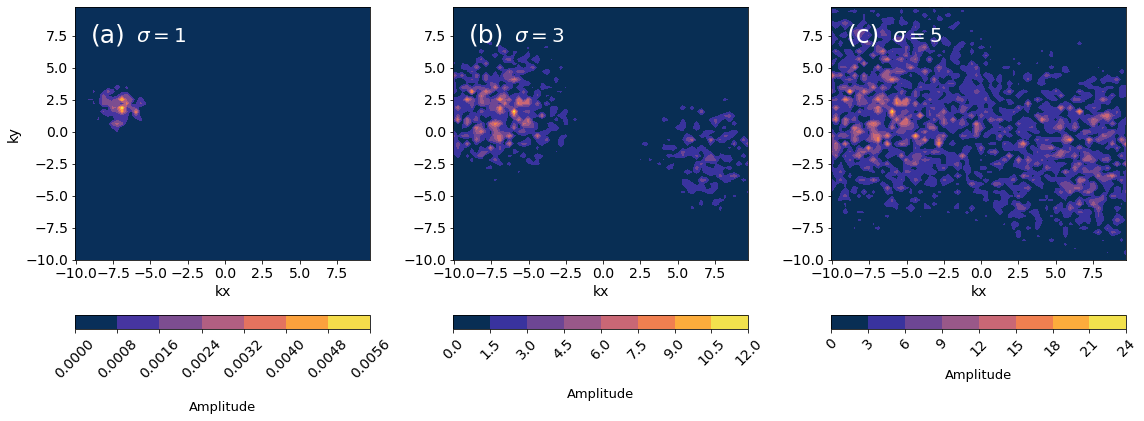

In [21]:
plt.rcParams["figure.figsize"] = (16,6)

plt.subplot(1, 3, 1)
plt.text(-9, 7.0, '(a)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 1$', fontsize = 20,c='white')
plt.contourf(k1, k2, np.abs(fft_filtered_gaus_full_full_1_ave[:,:,34]),cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14); plt.ylabel('ky',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.subplot(1, 3, 2)
plt.text(-9, 7.0, '(b)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 3$', fontsize = 20,c='white')
plt.contourf(k1, k2, np.abs(fft_filtered_gaus_full_full_3_ave[:,:,34]),cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.subplot(1, 3, 3)
plt.text(-9, 7.0, '(c)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 5$', fontsize = 20,c='white')
plt.contourf(k1, k2, np.abs(fft_filtered_gaus_full_full_5_ave[:,:,34]),cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=10, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.tight_layout()

plt.savefig('figure3.pdf')
plt.show()

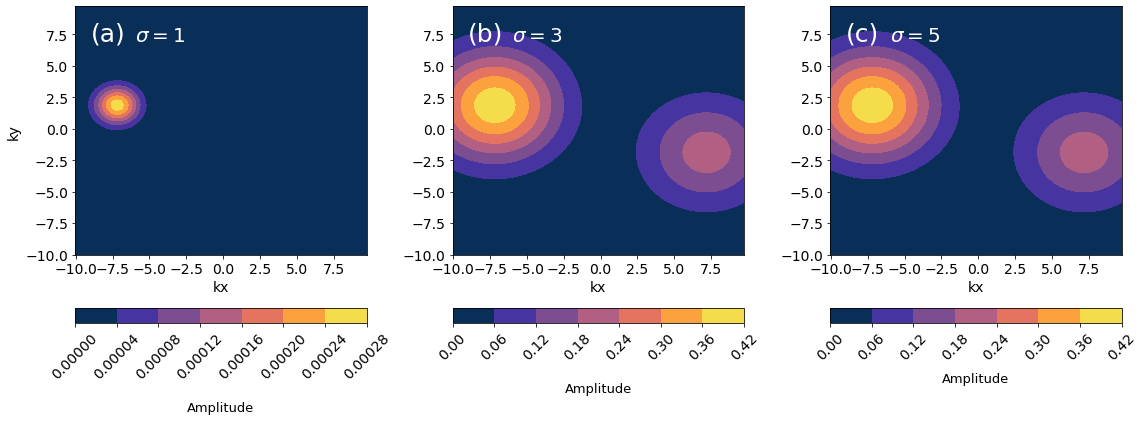

In [22]:
plt.rcParams["figure.figsize"] = (16,6)

plt.subplot(1, 3, 1)
plt.text(-9, 7.0, '(a)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 1$', fontsize = 20,c='white')
plt.contourf(k1, k2, g_vals_gaus_full_full_1_ave[:,:,34], cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14); plt.ylabel('ky',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.subplot(1, 3, 2)
plt.text(-9, 7.0, '(b)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 3$', fontsize = 20,c='white')
plt.contourf(k1, k2, g_vals_gaus_full_full_3_ave[:,:,34], cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=20, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.subplot(1, 3, 3)
plt.text(-9, 7.0, '(c)', fontsize = 25,c='white')
plt.text(-6, 7.0, r'$\sigma = 5$', fontsize = 20,c='white')
plt.contourf(k1, k2, g_vals_gaus_full_full_3_ave[:,:,34], cmap=cmocean.cm.thermal)
plt.xlabel('kx',fontsize=14)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('Amplitude', labelpad=10, y=0.45,fontsize=13, rotation=0)
cbar.ax.tick_params(rotation=45)
plt.xticks(fontsize= 14) ;plt.yticks(fontsize= 14) 
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(14)
        
plt.tight_layout()

plt.savefig('figure2.pdf')
plt.show()

In [23]:
x_posit_gaus_on_K_grid = []; y_posit_gaus_on_K_grid = [];z_posit_gaus_on_K_grid = []
for i in range(len(x_posit_gaus)):
    x_posit_gaus_on_K_grid.append(K_grid[x_posit_gaus[i]])
    y_posit_gaus_on_K_grid.append(K_grid[y_posit_gaus[i]])
    z_posit_gaus_on_K_grid.append(K_grid[z_posit_gaus[i]])

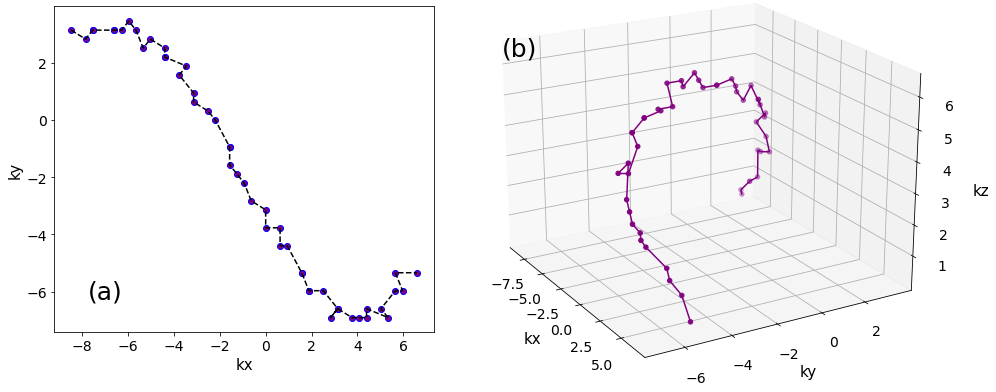

In [24]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=plt.figaspect(.4))

ax = fig.add_subplot(1, 2, 1)
ax.text(-7, -6, '(a)', horizontalalignment='center',verticalalignment='center',fontsize=25)

ax.plot(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, 'bo',
        x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, 'k--', markerfacecolor='purple')
ax.set_ylabel('ky',fontsize=15)
ax.set_xlabel('kx',fontsize=15)
ax.tick_params(labelsize=14)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.azim = -30; ax.dist = 7; ax.elev = 20
ax.text(-6, -8,7, '(b)', horizontalalignment='center',verticalalignment='center',fontsize=25)
ax.plot3D(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='purple')
ax.scatter(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='purple')
ax.set_xlabel('kx',fontsize=15); ax.set_ylabel('ky',fontsize=15); ax.set_zlabel('kz',fontsize=15)
ax.tick_params(labelsize=14)

plt.savefig('figure4.pdf')
plt.show()

In [35]:
# import plotly; import plotly.graph_objs as go
# from IPython.display import clear_output # utility for clearing output of cell as loop runs in notebook

# xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
# x = xx[0:N_grid];y = x; z = x

# xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting

# fft_filtered_gaus_full_ave = np.sum(fft_filtered_gaus_full, axis=3) / len_time
# normal_freq_abs = np.abs(fft_filtered_gaus_full_ave)/np.abs(fft_filtered_gaus_full_ave).max()

# fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
#                            value = normal_freq_abs.flatten(),isomin=.3, isomax=.7)
# fig = go.Figure(data=fig_data)
# fig.show()

# Exploring other filters

### Hard spherical filter

In [27]:
# ------------------------------------ a hard spherical filter # not sure if it works the way I would like
def sphere_centered(x, y, z, r):
    x_shift = shift(freq_max[1][1])
    y_shift = shift(freq_max[0][1])
    z_shift = shift(freq_max[2][1])
    
    x_shift_opp = shift(freq_max[1][0])
    y_shift_opp = shift(freq_max[0][0])
    z_shift_opp = shift(freq_max[2][0])
    
    cx_squared = (x - x_shift)**2
    cy_squared = (y - y_shift)**2
    cz_squared = (z - z_shift)**2
    
    cx_squared_opp = (x - x_shift_opp)**2
    cy_squared_opp = (y - y_shift_opp)**2
    cz_squared_opp = (z - z_shift_opp)**2
    
    r_squared = r**2
    condition1 = cx_squared + cy_squared + cz_squared
    condition2 = cx_squared_opp + cy_squared_opp + cz_squared_opp
    
    condition1 = np.where(condition1<=r_squared, 1, condition1); condition2 = np.where(condition2<=r_squared, 1, condition2)
    condition1 = np.where(condition1>r_squared , 0, condition1); condition2 = np.where(condition2>r_squared, 0, condition2) 
    condition = condition1+condition2
    return condition

In [28]:
radius = 5 # for spherical filter

x_posit_spher = []; y_posit_spher = []; z_posit_spher = []; submarine_position_spher = []; max_val_list_spher = []

denoised_spher = np.ndarray((64,64,64,49))
fft_filtered_spher_full = np.ndarray((64,64,64,49))

fft_full = np.ndarray((64,64,64,49))

for t in np.arange(49):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft = np.fft.fftshift(np.fft.fftn(signal))
    fft_full[:,:,:,t] = fft
    
    g_vals_spher = sphere_centered(kx3, ky3, kz3, radius) # spherical filter
    fft_filtered_spher = fft * g_vals_spher
    fft_filtered_spher_full[:,:,:,t] = fft_filtered_spher
    denoised_temp_spher = np.real(np.fft.ifftn(np.fft.ifftshift(fft_filtered_spher)))
    denoised_temp_normalized_spher = np.abs(denoised_temp_spher)/np.abs(denoised_temp_spher).max()
    max_pos_spher = np.unravel_index(denoised_temp_normalized_spher.argmax(), denoised_temp_normalized_spher.shape)
    max_val_spher = np.nanmax(denoised_temp_spher); max_val_list_spher.append(max_val_spher)
        
    submarine_position_spher.append(max_pos_spher)
    x_posit_spher.append(max_pos_spher[0]); y_posit_spher.append(max_pos_spher[1]); z_posit_spher.append(max_pos_spher[2])
    
    denoised_spher[:,:,:,t] = denoised_temp_spher

<ipython-input-28-ff2a16e168f3>:13: ComplexWarning:

Casting complex values to real discards the imaginary part

<ipython-input-28-ff2a16e168f3>:17: ComplexWarning:

Casting complex values to real discards the imaginary part



In [29]:
x_posit_spher_on_K_grid = []; y_posit_spher_on_K_grid = [];z_posit_spher_on_K_grid = []
for i in range(len(x_posit_spher)):
    x_posit_spher_on_K_grid.append(K_grid[x_posit_spher[i]])
    y_posit_spher_on_K_grid.append(K_grid[y_posit_spher[i]])
    z_posit_spher_on_K_grid.append(K_grid[z_posit_spher[i]])

In [34]:
# fig = plt.figure(figsize=plt.figaspect(.4))

# ax = fig.add_subplot(1, 2, 1)
# ax.text(-7, -6, '(a)', horizontalalignment='center',verticalalignment='center',fontsize=25)

# ax.plot(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, 'bo',
#         x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, 'k--', markerfacecolor='blue',label='spherical filter',alpha=0.5)
# ax.plot(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, 'bo',
#         x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, 'red', markerfacecolor='red',label='gaussian filter',alpha=0.5)
# ax.set_ylabel('y on K grid')
# ax.set_xlabel('x on K grid')
# ax.legend()

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.azim = -30; ax.dist = 7; ax.elev = 20
# ax.text(-6, -8,7, '(b)', horizontalalignment='center',verticalalignment='center',fontsize=25)
# # ------ spherical filter
# ax.plot3D(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, z_posit_spher_on_K_grid,c='blue',label='spherical filter')
# ax.scatter(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, z_posit_spher_on_K_grid,c='blue')
# # ------ gaussian filter
# ax.plot3D(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='red',label='gaussian filter')
# ax.scatter(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='red')

# ax.set_xlabel('x on K grid'); ax.set_ylabel('y on K grid'); ax.set_zlabel('z on K grid')
# ax.legend()
# plt.show()

### Exploring Scipy offerings: Scipy percentile filter

In [31]:
from scipy import ndimage
x_posit = []; y_posit = []; z_posit = []; submarine_position = []

denoised = np.ndarray((64,64,64,49))

for t in np.arange(49):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    result = ndimage.percentile_filter(signal, percentile=80, size=3)

    denoised_temp_normalized = np.abs(result)/np.abs(result).max()
    max_pos = np.unravel_index(denoised_temp_normalized.argmax(), denoised_temp_normalized.shape)
    
    submarine_position.append(max_pos)    
    x_posit.append(max_pos[0]); y_posit.append(max_pos[1]); z_posit.append(max_pos[2])
    
    denoised[:,:,:,t] = result

In [32]:
x_posit_on_K_grid = []; y_posit_on_K_grid = [];z_posit_on_K_grid = []
for i in range(len(x_posit_spher)):
    x_posit_on_K_grid.append(K_grid[x_posit[i]])
    y_posit_on_K_grid.append(K_grid[y_posit[i]])
    z_posit_on_K_grid.append(K_grid[z_posit[i]])

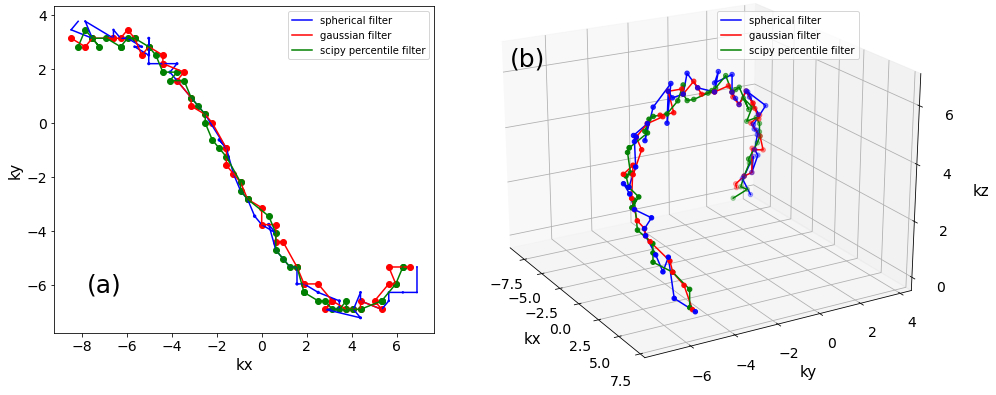

In [33]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=plt.figaspect(.4))

ax = fig.add_subplot(1, 2, 1)
ax.text(-7, -6, '(a)', horizontalalignment='center',verticalalignment='center',fontsize=25)

ax.plot(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid,c='blue',label='spherical filter')
ax.scatter(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, z_posit_spher_on_K_grid,c='blue')

ax.plot(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid,c='red',label='gaussian filter')
ax.scatter(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid,c='red')

ax.plot(x_posit_on_K_grid, y_posit_on_K_grid,c='green',label='scipy percentile filter')
ax.scatter(x_posit_on_K_grid, y_posit_on_K_grid,c='green')
ax.legend(loc='upper right')

ax.set_ylabel('ky',fontsize=15)
ax.set_xlabel('kx',fontsize=15)
ax.tick_params(labelsize=14)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.azim = -30; ax.dist = 7; ax.elev = 20
ax.text(-6, -8,7, '(b)', horizontalalignment='center',verticalalignment='center',fontsize=25)
# ------ spherical filter
ax.plot3D(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, z_posit_spher_on_K_grid,c='blue',label='spherical filter')
ax.scatter(x_posit_spher_on_K_grid, y_posit_spher_on_K_grid, z_posit_spher_on_K_grid,c='blue')
# ------ gaussian filter
ax.plot3D(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='red',label='gaussian filter')
ax.scatter(x_posit_gaus_on_K_grid, y_posit_gaus_on_K_grid, z_posit_gaus_on_K_grid,c='red')
# ------ scipy percentile filter
ax.plot3D(x_posit_on_K_grid, y_posit_on_K_grid, z_posit_on_K_grid,c='green',label='scipy percentile filter')
ax.scatter(x_posit_on_K_grid, y_posit_on_K_grid, z_posit_on_K_grid,c='green')
ax.tick_params(labelsize=14)
ax.legend(loc='upper right')
ax.set_xlabel('kx',fontsize=15); ax.set_ylabel('ky',fontsize=15); ax.set_zlabel('kz',fontsize=15)

plt.savefig('figure5.pdf')
plt.show()